# Nootebook to calculate the coordinates of the DLAs

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

### Read the data from both files

In [2]:
# specify the path to the file with Lyman alpha skewers, with (ON) self-shielding 
fname_on='/data/desi/common/astrid/spectra_ASTRID_z2.5_500x500x2500.hdf5'

In [3]:
with h5py.File(fname_on,'r') as f:
    tau_on = f['tau/H/1/1215'][:]
    colden = f['colden']['H/1'][:]
    axes = f['spectra/axes'][:]
    # (x,y,z) start of the skewers, in kpc/h
    cofm_hkpc = f['spectra/cofm'][:]

### Define the functions to find the skewers

In [4]:
# box lenght in Mpc/h
# this information should be stored in the HDF5, but I couldn't find it... so added it by hand
L_hMpc=250
# number of skewers per side (500)
Nsk=int(np.sqrt(colden.shape[0]))
print(Nsk,'skewers per side')
# number of pixels / cells per skewer (2500)
Np=int(colden.shape[1])
print(Np,'pixels per skewer')
# pixel width (in Mpc/h)
dz_hMpc=L_hMpc/Np
print('pixel width = {:.3f} Mpc/h'.format(dz_hMpc))
# minimum separation between skewers (in Mpc/h)
dxy_hMpc=L_hMpc/Nsk
print('skewer separation = {:.3f} Mpc/h'.format(dxy_hMpc))

500 skewers per side
2500 pixels per skewer
pixel width = 0.100 Mpc/h
skewer separation = 0.500 Mpc/h


In [5]:
def skewer_index(ix, iy):
    """Given the ix, iy indices, return the global index of a given skewer"""
    return ix*Nsk+iy

In [6]:
def skewer_ix_iy(isk):
    """Given the global index, return the (ix, iy) indices of a skewer"""
    ix=isk//Nsk
    iy=isk-ix*Nsk    
    return ix, iy

In [7]:
def skewer_xy_hMpc(isk):
    """Return the (x,y) coordinates of a given skewer, in Mpc/h"""
    ix, iy = skewer_ix_iy(isk)
    return dxy_hMpc*ix, dxy_hMpc*iy

### Find all the skewers with a certain maximum column density

In [8]:
max_colden=np.max(colden.reshape([Nsk,Nsk,Np]),axis=2) #Define the maximum column density

In [11]:
coordinates = np.array([]) #Array of sets of coordinates
for k in range(1,10):
    coordinates[k] = {
    "x": np.array([]),
    "y": np.array([]),
    "z": np.array([])
    }
    for i in range(Nsk):
        for j in range(Nsk):
            if k*1e22 < max_colden[i][j] < (k+1)*1e22:
                coordinates[k]["x"] = np.append(coordinates[k]["x"], dxy_hMpc*i)
                coordinates[k]["y"] = np.append(coordinates[k]["y"], dxy_hMpc*j)
    for i in range(max(len(coordinates[k]["x"]), len(coordinates[k]["y"]))):
        coordinates[k]["z"] = np.append(coordinates[k]["z"], dz_hMpc*np.argmax(tau_on[int(skewer_index(coordinates[k]["x"][i],coordinates[k]["y"][i]))]))

IndexError: index 1 is out of bounds for axis 0 with size 0

### We can plot some of the skewers with DLAs

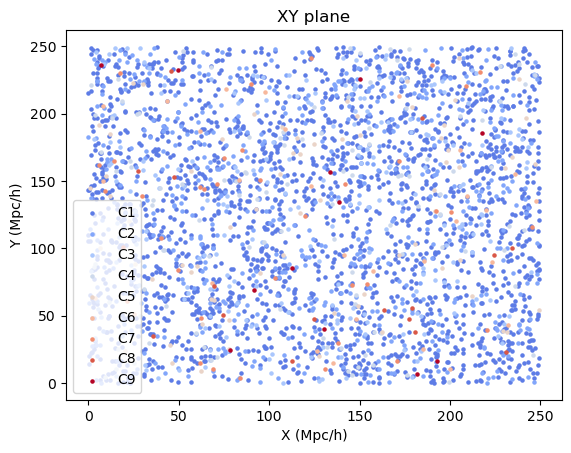

In [40]:
cmap = plt.cm.coolwarm
colors = cmap(np.linspace(0, 1, 10))
for i in range(1,10):
    plt.scatter(coordinates[i]["x"], coordinates[i]["y"], color = colors[i], label = "C"+str(i), s=5)
    
plt.xlabel("X (Mpc/h)")
plt.ylabel("Y (Mpc/h)")
plt.title("XY plane")
plt.legend()



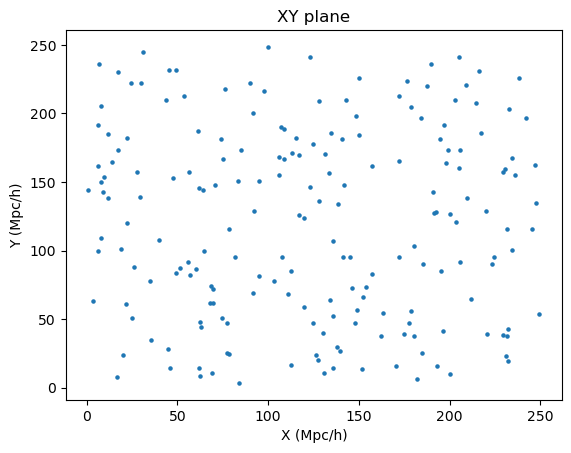

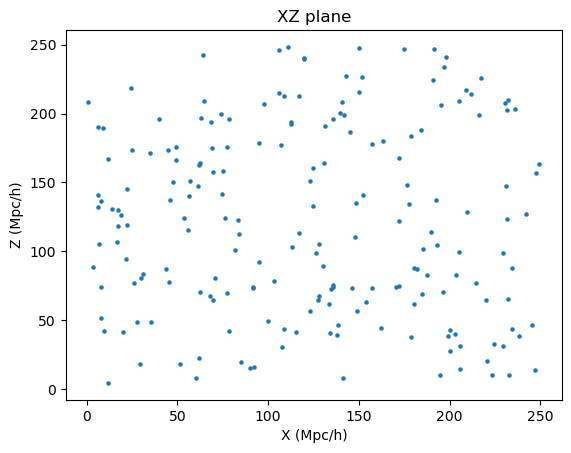

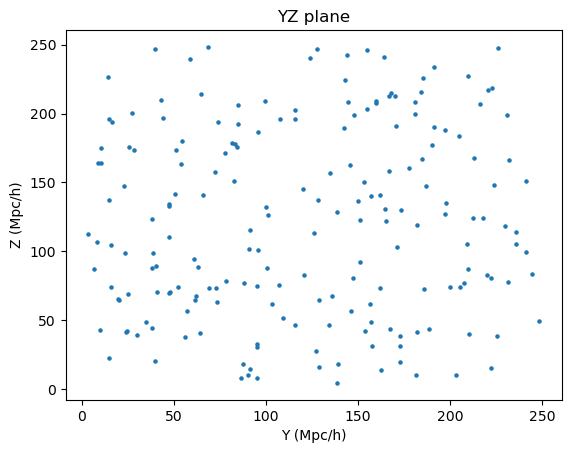

In [17]:
plt.scatter(coordinates["x"], coordinates["y"], s=5)
plt.xlabel("X (Mpc/h)")
plt.ylabel("Y (Mpc/h)")
plt.title("XY plane")

plt.show()
plt.scatter(coordinates["x"], coordinates["z"], s=5)
plt.xlabel("X (Mpc/h)")
plt.ylabel("Z (Mpc/h)")
plt.title("XZ plane")

plt.show()
plt.scatter(coordinates["y"], coordinates["z"], s=5)
plt.xlabel("Y (Mpc/h)")
plt.ylabel("Y (Mpc/h)")
plt.title("YZ plane")

plt.show()


In [13]:
from mpl_toolkits.mplot3d import Axes3D

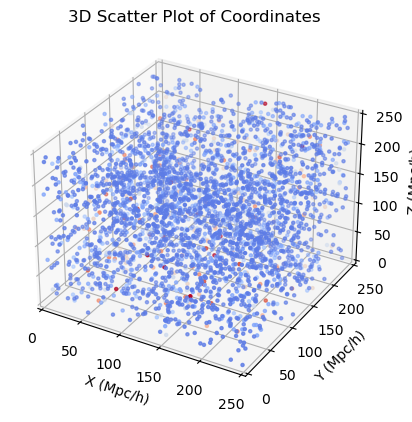

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = plt.cm.coolwarm
colors = cmap(np.linspace(0, 1, 10))

for i in range(1,10):
    ax.scatter(coordinates[i]["x"], coordinates[i]["y"], coordinates[i]["z"], color = colors[i], label = "C"+str(i), s=5)
    
ax.set_xlabel('X (Mpc/h)')
ax.set_ylabel('Y (Mpc/h)')
ax.set_zlabel('Z (Mpc/h)')
ax.set_xlim([0, 250])
ax.set_ylim([0, 250])
ax.set_zlim([0, 250])
ax.set_title('3D Scatter Plot of Coordinates')
plt.savefig('3d_plot')

plt.show()

### Function to calculate the coordinates

In [9]:
def HCDs_coords(mincolden, maxcolden):
    
    L_hMpc = 250
    Nsk = int(np.sqrt(colden.shape[0]))  # 500
    Np = int(colden.shape[1])            # 2500
    dz_hMpc = L_hMpc / Np
    dxy_hMpc = L_hMpc / Nsk

    # Build i and j grids
    i_vals = np.arange(Nsk**2)
    j_vals = np.arange(Np)
    i_grid, j_grid = np.meshgrid(i_vals, j_vals, indexing='ij')  # shape (Nsk^2, Np)

    # Mask where column density is in desired range
    mask = (colden > mincolden) & (colden < maxcolden)

    # Flatten everything where mask is True
    i_valid = i_grid[mask]
    j_valid = j_grid[mask]

    # Compute ix, iy from i
    ix = i_valid % Nsk
    iy = i_valid // Nsk

    # Final coordinates
    x = dxy_hMpc * ix
    y = dxy_hMpc * iy
    z = dz_hMpc * j_valid

    return {
        "x": x,
        "y": y,
        "z": z
    }
